In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from sift import *
import glob
import os
import json
import copy
import math
import random
import gc
import tqdm
import seaborn as sns
import pickle
import pandas as pd

In [2]:
def evaluate_homography(scale, gaussian_kernel, do_skeletonize, keypoints_finder_name, train_set=True):
    baseline = cv.imread('baseline.png',0)
    crop_height=0
    crop_width=0
    baseline = baseline[crop_height:baseline.shape[0]-crop_height, crop_width:baseline.shape[1]-crop_width]
    test_images = []
    test_points = []
    
    saved_baseline = np.copy(baseline) 
    
    if(train_set):
        path = "points_full_predictions_train/*.png"
        path_length = 29
    else:
        path = "points_full_predictions/*.png"
        path_length = 24
    filenames = []
    for filename in glob.glob(path):
        test_images.append(cv.imread(filename,0))
        filenames.append(filename[path_length:-4])
        with open(f"points_transformed/{filename[path_length:-4]}.json","r") as json_file:
            test_points.append(json.load(json_file))
        
    baseline = cv.resize(baseline, (0,0), fx=scale, fy=scale)
    if do_skeletonize:
        baseline = (skeletonize(baseline/255)*255).astype(np.uint8)
    baseline = cv.GaussianBlur(baseline,gaussian_kernel,0)
    
    
    distances = []

    well_georeferenced = 0
    badly_georeferenced = 0
    for test_image, test_point, filename in zip(test_images, test_points, filenames):
        test_image = cv.resize(test_image, (0,0), fx=scale, fy=scale)
        if do_skeletonize:
            test_image = (skeletonize(test_image/255)*255).astype(np.uint8)
        test_image = cv.GaussianBlur(test_image,gaussian_kernel,0)
        
        try:
            M = get_homography(test_image, baseline, 10, keypoints_finder_name)
        except:
            badly_georeferenced += 1
            continue
        if not type(M) == np.ndarray:
            badly_georeferenced += 1
            continue

        pts = np.float32([[x*scale,y*scale] for x,y in zip(test_point["x"], test_point["y"])]).reshape(-1,1,2)
        targets = np.float32([[(x-crop_width)*scale,(y-crop_height)*scale] for x,y in zip(test_point["x_"], test_point["y_"])])
        p_transformed = cv.perspectiveTransform(pts,M).reshape(-1,2)
        dst = [math.sqrt((target_x - p_transformed_x)**2 + (target_y - p_transformed_y)**2)*1.19 for ((target_x, target_y), (p_transformed_x, p_transformed_y)) in zip (targets, p_transformed)]
        distances += dst
        if np.mean(dst) < 100:
            well_georeferenced += 1
            color=(0,255,0)
        else:
            badly_georeferenced += 1
            color=(255,0,0)
            
    return badly_georeferenced, distances

In [3]:
b, distances = evaluate_homography(0.25, (17,17), True, "sift", train_set=False)

In [4]:
with open('superglue_distances.pickle', 'rb') as handle:
    superglue_distances = pickle.load(handle)


In [5]:
df = pd.DataFrame()
sift_values = pd.Series(distances)
superglue_values = pd.Series(superglue_distances)

df.insert(loc=0, column='sift', value=sift_values)
df.insert(loc=0, column='superglue', value=superglue_values)

In [6]:
s = 0
c = 0
for d in superglue_values:
    if d < 100:
        s+=d
        c+=1
print(s/c)

28.39489960862625


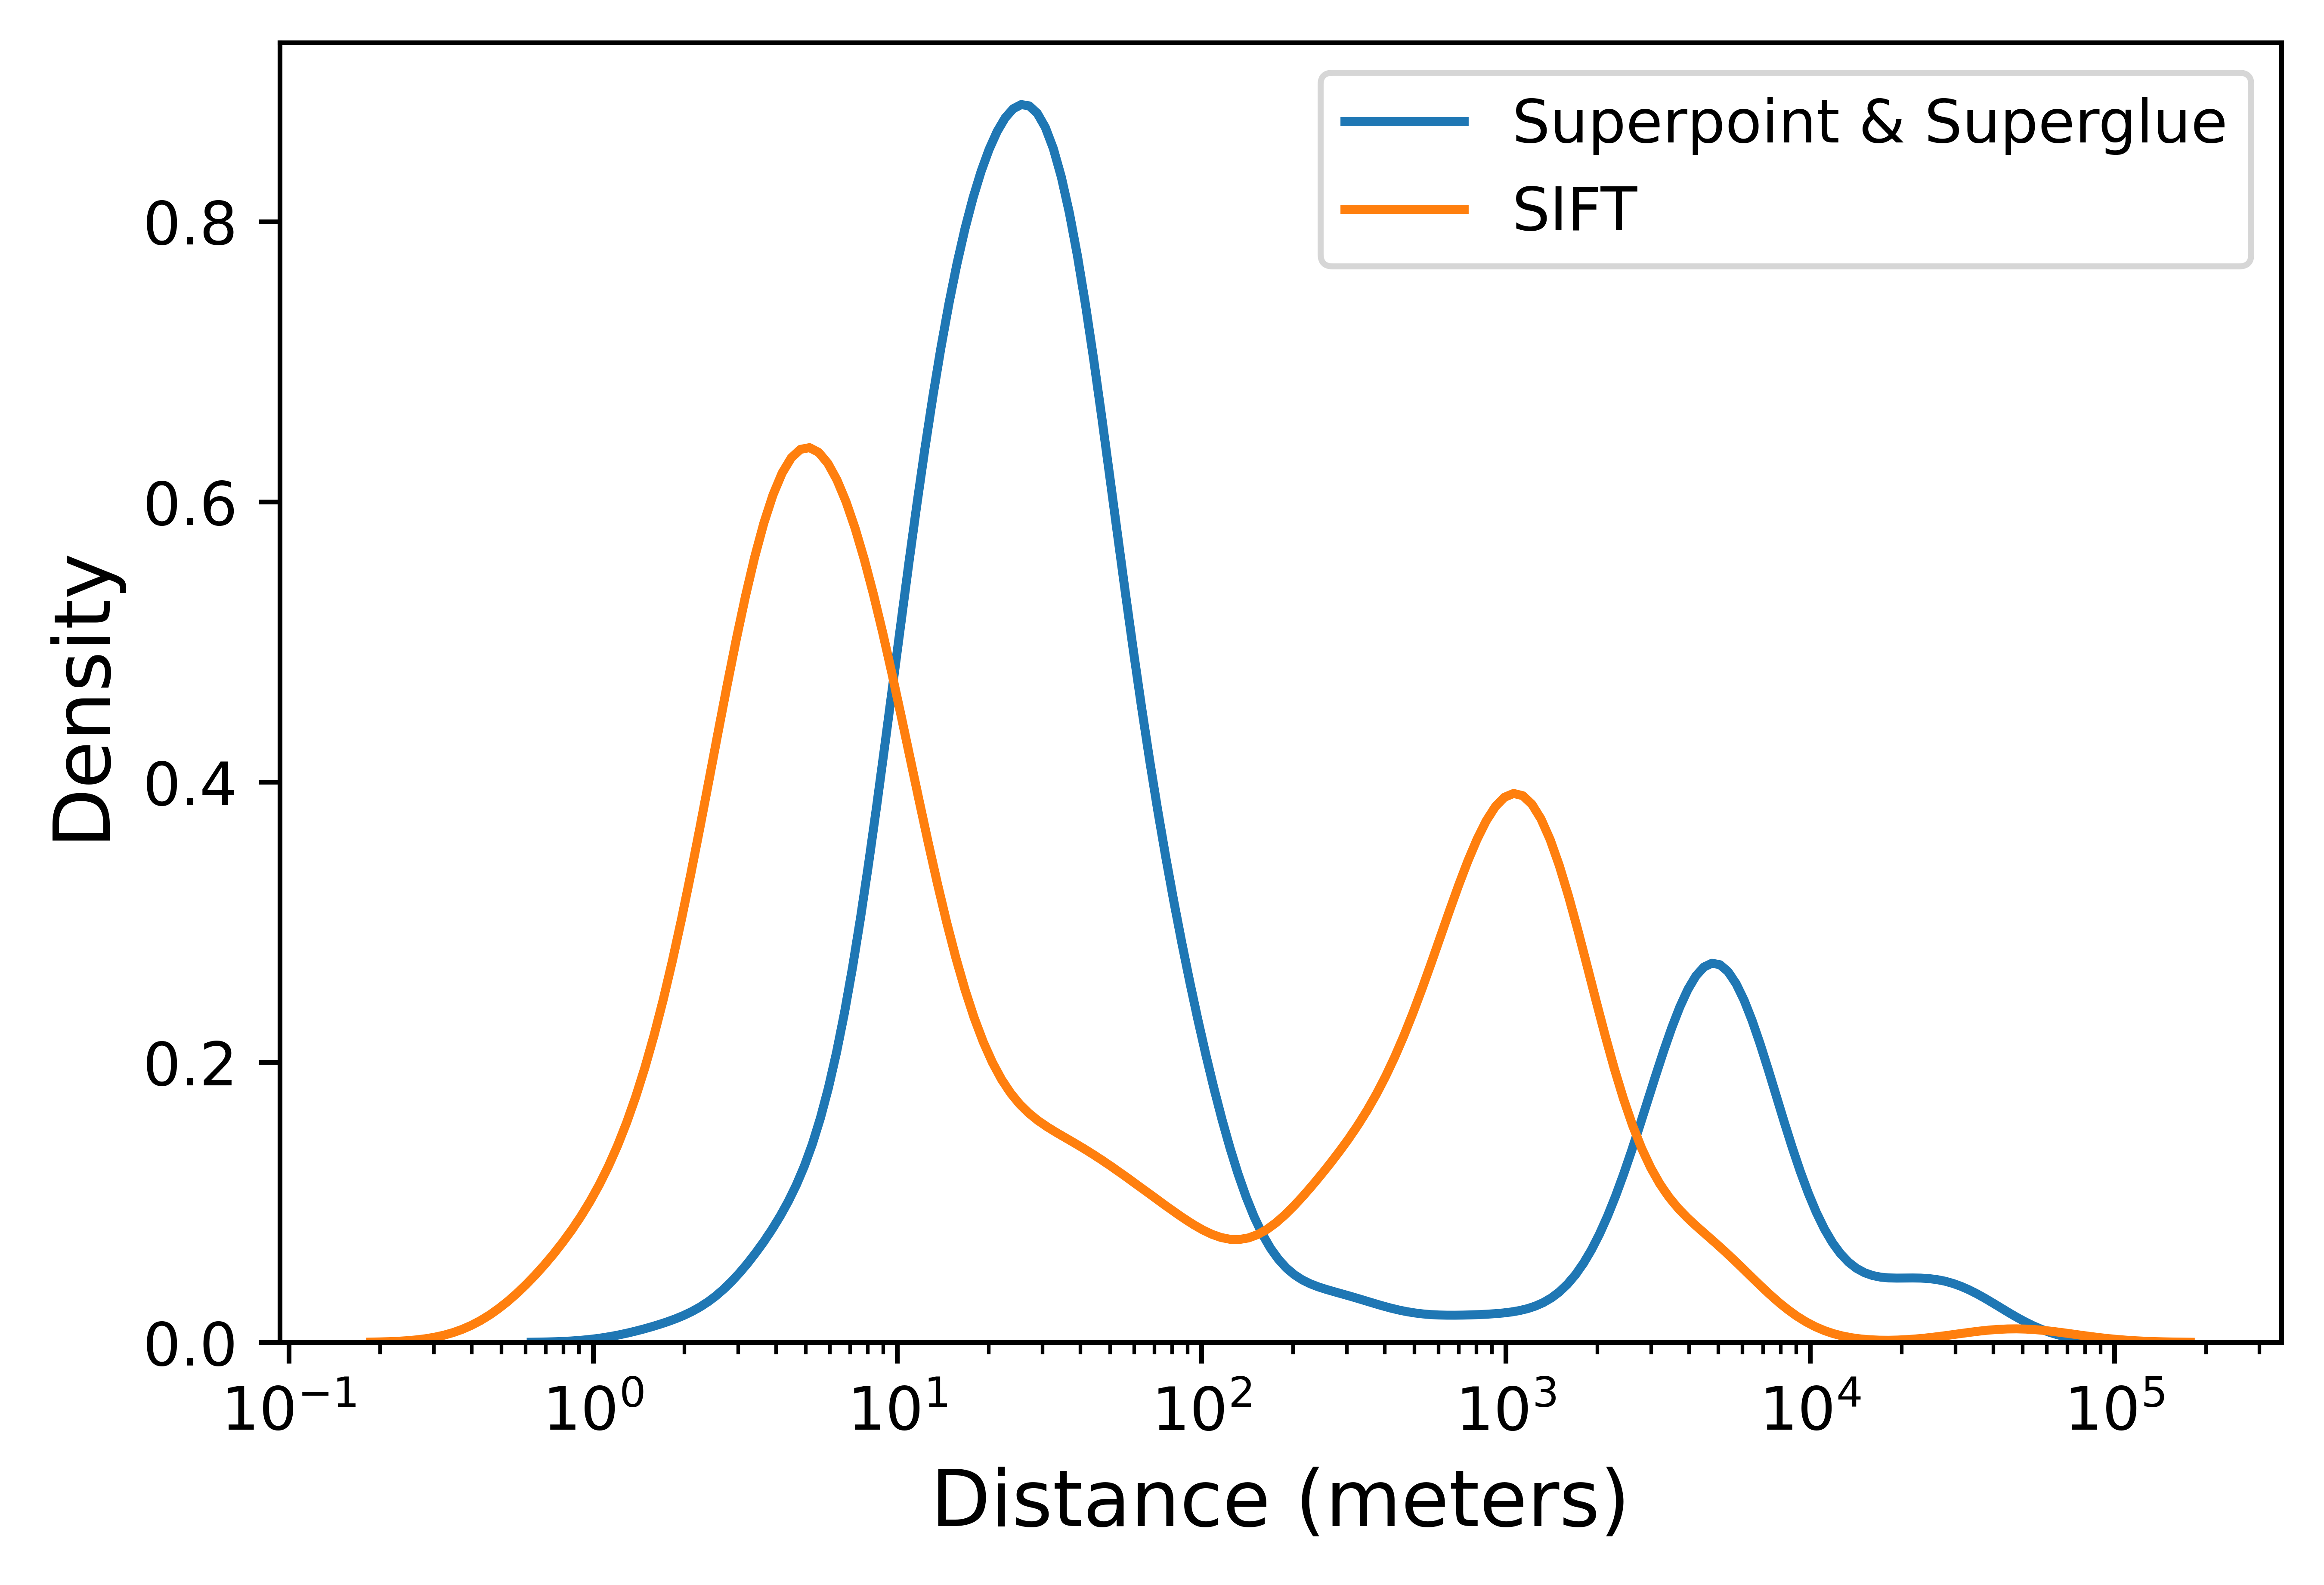

In [7]:
sns.reset_orig()
f, ax = plt.subplots(figsize=(6, 4), dpi=1000)
ax.set(xscale="log")
sns.kdeplot(data=df, x="superglue", ax=ax, bw_adjust=0.5, label="Superpoint & Superglue")
sns.kdeplot(data=df, x="sift", ax=ax, bw_adjust=0.5, label="SIFT")
ax.set_ylabel("Density", fontsize=13)
ax.set_xlabel("Distance (meters)", fontsize=13)
ax.legend()

plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text

ax.get_figure().savefig("sift_and_superglue_results.png")

# solutions = []
keypoints_finders = ["sift", "orb", "brisk"]
num_keypoints_finder = 0
for s in range(10):
    kernel = random.randint(10,80)
    if kernel % 2 == 0:
        kernel += 1
    solutions.append( ( random.uniform(0.2,0.6), kernel, random.random() >0.5, keypoints_finders[num_keypoints_finder]))
solutions

In [15]:
for e in tqdm.tqdm(range(50)):
    ranked_solutions = []
    for s in solutions:
        ranked_solutions.append((evaluate_homography(s[0], (s[1], s[1]), s[2], s[3]),s))
    ranked_solutions.sort()
    print(f"Gen {e} best solution : {ranked_solutions[0][1]} with fitness {ranked_solutions[0][0]}")
    best_solutions = ranked_solutions[:5]
    
    scales = []
    kernels = []
    do_skeletonizes = []
    for s in best_solutions:
        scales.append(s[1][0])
        kernels.append(s[1][1])
        do_skeletonizes.append(s[1][2])

    new_gen = []
    for i in range(10):
        scale = random.choice(scales) + random.uniform(-0.03, 0.03)
        kernel = random.choice(kernels) + random.randint(-2,2)
        if kernel % 2 == 0:
            kernel += 1
        do_skeletonize = random.choice(do_skeletonizes)
        do_skeletonize = do_skeletonize if random.random() < 0.8 else not do_skeletonize
        
        
        new_gen.append((scale, kernel, do_skeletonize, keypoints_finders[num_keypoints_finder]))
    solutions = new_gen

  2%|█▌                                                                            | 1/50 [31:19<25:34:43, 1879.26s/it]

Gen 0 best solution : (0.21721009011846368, 43, False, 'sift') with fitness 40


  4%|███                                                                           | 2/50 [47:57<18:08:51, 1361.08s/it]

Gen 1 best solution : (0.21223396026759195, 81, False, 'sift') with fitness 40


  6%|████▌                                                                       | 3/50 [1:00:23<14:05:59, 1079.98s/it]

Gen 2 best solution : (0.18702276178310806, 45, True, 'sift') with fitness 40


  8%|██████▏                                                                      | 4/50 [1:09:30<11:06:52, 869.84s/it]

Gen 3 best solution : (0.1721603461114996, 45, False, 'sift') with fitness 40


 10%|███████▊                                                                      | 5/50 [1:17:28<9:06:13, 728.31s/it]

Gen 4 best solution : (0.1508146192149013, 49, True, 'sift') with fitness 40


 12%|█████████▎                                                                    | 6/50 [1:23:39<7:25:00, 606.82s/it]

Gen 5 best solution : (0.14527274780754304, 47, False, 'sift') with fitness 40


 14%|██████████▉                                                                   | 7/50 [1:28:34<6:01:50, 504.91s/it]

Gen 6 best solution : (0.11746007628303363, 49, False, 'sift') with fitness 40


 16%|████████████▍                                                                 | 8/50 [1:32:36<4:54:56, 421.34s/it]

Gen 7 best solution : (0.1139688572742914, 45, True, 'sift') with fitness 40


 18%|██████████████                                                                | 9/50 [1:36:13<4:04:09, 357.29s/it]

Gen 8 best solution : (0.10414478811891043, 53, False, 'sift') with fitness 40


 20%|███████████████▍                                                             | 10/50 [1:39:36<3:26:34, 309.87s/it]

Gen 9 best solution : (0.08215267607629649, 49, False, 'sift') with fitness 40


 22%|████████████████▉                                                            | 11/50 [1:42:12<2:50:48, 262.78s/it]

Gen 10 best solution : (0.05463639961770528, 53, True, 'sift') with fitness 40


 24%|██████████████████▍                                                          | 12/50 [1:44:19<2:20:09, 221.30s/it]

Gen 11 best solution : (0.04458210960874054, 53, True, 'sift') with fitness 40


 26%|████████████████████                                                         | 13/50 [1:46:10<1:55:51, 187.87s/it]

Gen 12 best solution : (0.024608106473086457, 47, True, 'sift') with fitness 40


 28%|█████████████████████▌                                                       | 14/50 [1:47:51<1:36:57, 161.59s/it]

Gen 13 best solution : (0.01721221859492296, 45, True, 'sift') with fitness 40


 30%|███████████████████████                                                      | 15/50 [1:49:28<1:22:54, 142.12s/it]

Gen 14 best solution : (0.0029579464546566347, 47, True, 'sift') with fitness 40


 30%|███████████████████████                                                      | 15/50 [1:50:38<4:18:10, 442.58s/it]


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4055: error: (-215:Assertion failed) inv_scale_x > 0 in function 'cv::resize'
